# ITU-T G.227 の周波数特性

ITU-T G.227 https://www.itu.int/rec/T-REC-G.227-198811-I/en


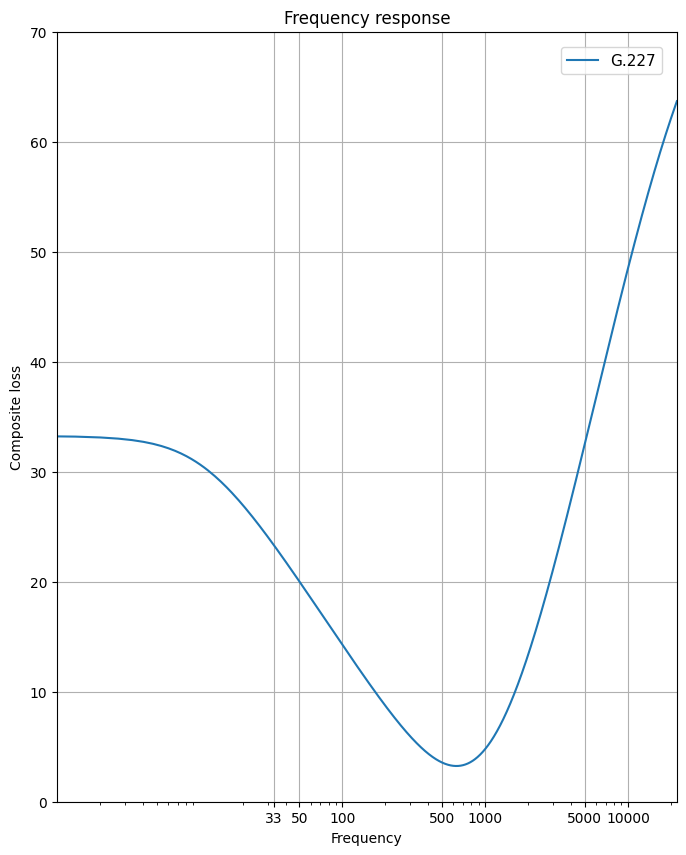

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import json

def g227(niq, size):
    f = np.linspace(0, niq, size)
    p = 1j * f / 1000
    numerator = 18400 + 91238*p**2 + 11638*p**4 + p*(67280 + 54050*p**2)
    denominator = 400 + 4001*p**2 + p**4 + p*(36040 + 130*p**2)
    loss = np.abs(numerator / denominator)
    return f, loss

sr = 44100
xticks = [33, 50, 100, 500, 1000, 5000, 10000]
f_m, loss_m = g227(sr/2, 2**15)

plt.figure(figsize=(8,10))
plt.title("Frequency response")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Composite loss')
plt.xlabel('Frequency')
plt.ylim((0, 70))
#plt.xlim((33, 10000))
plt.xlim((1, sr/2))
plt.xticks(xticks, xticks)
plt.plot(f_m, 20 * np.log10(loss_m), label="G.227")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

# アナログプロトタイプ

アナログフィルタの係数を計算する。以下は規格書に掲載されているアナログフィルタの式だが、p=f/1000 (Hz) になっているのを角周波数 ω をとる関数にする

$$ H(p) = 
\frac{
  11638\ p^4 + 54050\ p^3 + 91238\ p^2  + 67280\ p + 18400
}{
  p^4 + 130\ p^3 + 4001\ p^2 + 36040\ p + 400
} $$

$$
p = j \frac{\omega}{2000 \pi}
$$

以下の形にして係数を計算しなおす

$$ H(\omega) = \frac{
  11638\ (2000\pi)^{-4} ({j\omega})^4 +
  54050\ (2000\pi)^{-3} ({j\omega})^3 +
  91238\ (2000\pi)^{-2} ({j\omega})^2 +
  67280\ (2000\pi)^{-1} ({j\omega}) +
  18400
}{
         (2000\pi)^{-4}  ({j\omega})^4 +
  130\   (2000\pi)^{-3} ({j\omega})^3 +
  4001\  (2000\pi)^{-2} ({j\omega})^2 +
  36040\ (2000\pi)^{-1} ({j\omega}) +
  400
} $$

biquad フィルタのみで構成する場合は、同じく G.227 に書いてあるネットワークを利用する

$$
\begin{eqnarray}
H(p) = \frac{ 46 p^2 + 90 p + 46 }{ p^2 + 90 p + 1 } \\
H(p) = \frac{ 11 p + 20  }{ p + 20 } \\
H(p) = \frac{ 23 p + 20  }{ p + 20 } \\
\end{eqnarray}
$$

いずれにしてもこれはゲインの関数になっていて、フィルタとしては分母と分子が逆なので気をつける。

これを双一次変換してデジタルフィルタを得る `filtz = signal.lti(*signal.bilinear(num, den, sr))` の部分

最大誤差とその周波数: Max Error 17.76676235510319 dB at 21666.439819335934 Hz
二乗平均平方根誤差: RMSE 10.434663310271596 dB


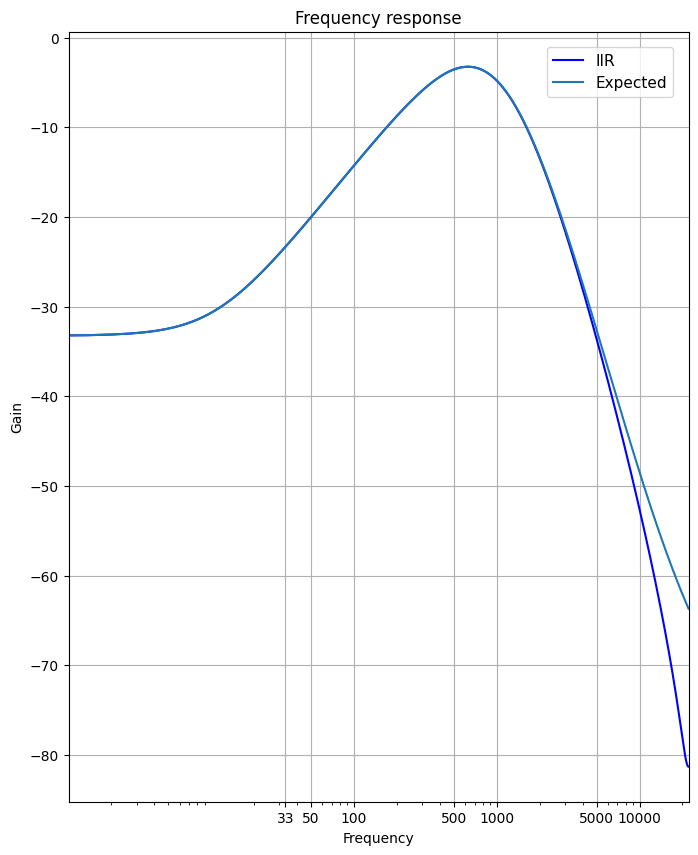

In [39]:
# biquad フィルタのみで構成する場合
network = [
    [
        [1, 90, 1],
        [46, 90, 46]
    ],
    [
        [0, 1, 20],
        [0, 11, 20]
    ],
    [
        [0, 1, 20],
        [0, 23, 20]
    ]
]

# 4次のIIRフィルタで構成する場合
network = [
    [
        [1, 130, 4001, 36040, 400],
        [11638, 54050, 91238, 67280, 18400]
    ]
]

filters = []

for (num, den) in network:
    num = [ x * ( (2 * np.pi * 1000)**-(4-i) ) for i, x in enumerate(num) ]
    den = [ x * ( (2 * np.pi * 1000)**-(4-i) ) for i, x in enumerate(den) ]

    # 双一次変換
    filtz = signal.lti(*signal.bilinear(num, den, sr))
    wz, hz = signal.freqz(filtz.num, filtz.den, worN=2**15)
    ws, hs = signal.freqs(num, den, worN=sr*wz)
    filters.append({
        "filter": filtz,
        "wz": wz,
        "hz": hz,
    })

    plt.figure(figsize=(8,10))
    plt.title("Frequency response")
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('Gain')
    plt.xlabel('Frequency')
    #plt.ylim((0, 70))
    plt.xlim((33, 10000))
    plt.xlim((1, sr/2))
    plt.xticks(xticks, xticks)

    freqz_dB = 20 * np.log10(np.abs(hz))
    expected_dB =  -20 * np.log10(loss_m)

    plt.plot(wz*sr/(2*np.pi), 20 * np.log10(np.abs(hz)), 'b', label="IIR")
    plt.plot(wz*sr/(2*np.pi), 20 * np.log10(np.abs(hs)), label="Expected")
    #plt.plot(f_m, -20 * np.log10(loss_m), label="expected")

    error = np.abs(freqz_dB - expected_dB)
    print('最大誤差とその周波数: Max Error', np.max(error), 'dB', 'at', wz[np.argmax(error)]*sr/(2*np.pi), 'Hz')
    print('二乗平均平方根誤差: RMSE',  20*np.log10(np.sqrt(np.mean(np.power(10, error / 20)**2))), 'dB')

    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

    plt.show()

# FIR フィルタで補正する

双一次変換の IIR フィルタには誤差(歪み)が残る。特にナイキスト周波数に近いほど大きくなる。これを FIR フィルタで補正する。
FIR フィルタは高域の補正は短い長さですむ。

まず補正する周波数特性を算出する

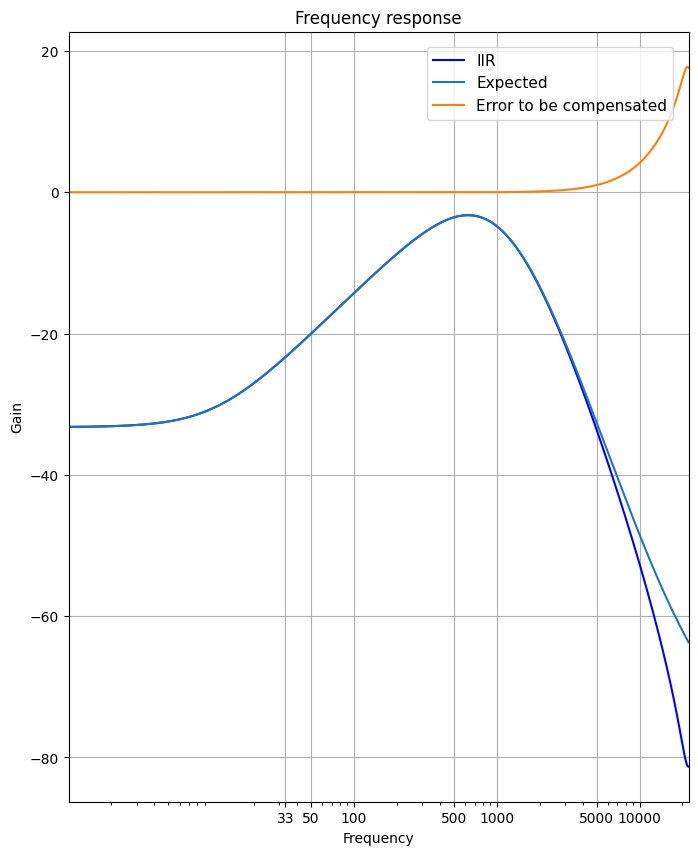

In [40]:
h =  np.multiply.reduce([ np.abs(f["hz"]) for f in filters])
x = filters[0]["wz"]*sr/(2*np.pi)
diff =   -20 * np.log10(loss_m) - 20 * np.log10(np.abs(h))
diff = np.power(10, diff / 20)
plt.figure(figsize=(8,10))
plt.title("Frequency response")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
#plt.ylim((-100, 0))
#plt.xlim((33, 10000))
plt.xlim((1, sr/2))
plt.xticks(xticks, xticks)
plt.plot(x, 20 * np.log10(np.abs(h)), 'b', label="IIR")
plt.plot(f_m, -20 * np.log10(loss_m), label="Expected")
plt.plot(f_m, 20 * np.log10(diff), label="Error to be compensated")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

実数フィルタにするため、左右対称にして IFFT してインパルスレスポンスを得る

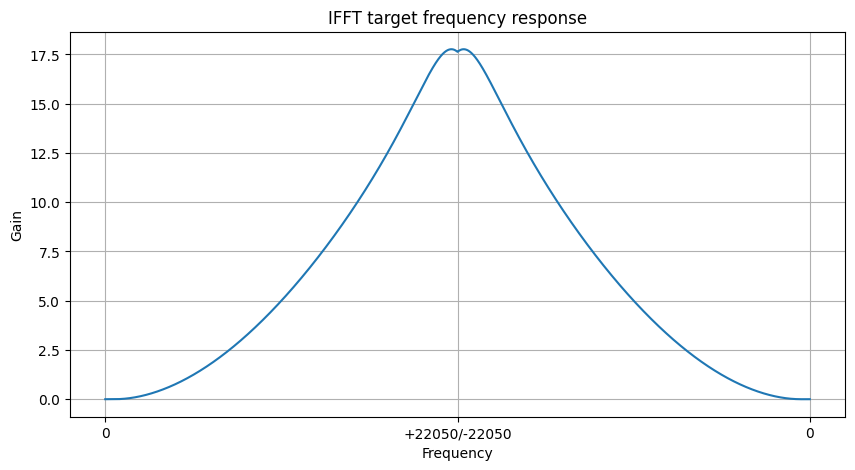

97


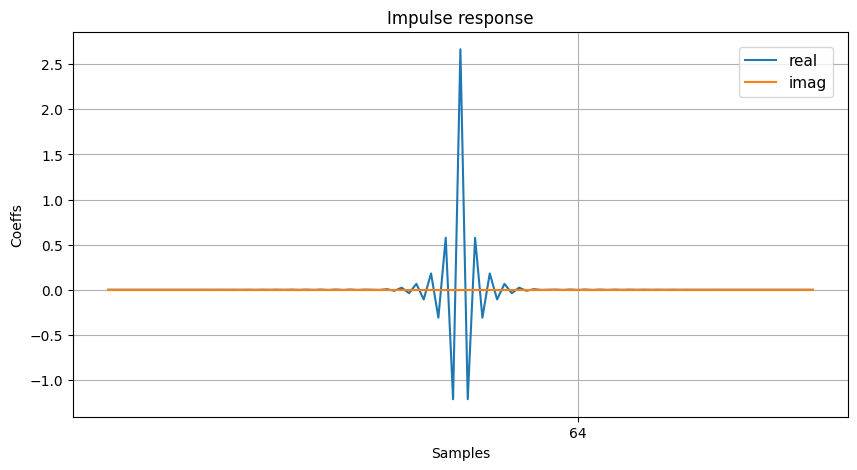

In [41]:
gain = list(diff) + list(diff[::-1])
plt.figure(figsize=(10,5))
plt.title("IFFT target frequency response")
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
plt.plot( 20 * np.log10(gain))
plt.xticks([0, len(gain)/2, len(gain)-1], [0, "+%d/-%d" % (sr/2, sr/2), 0])
plt.show()

# 1. 対称な周波数応答の作成
H_desired = np.concatenate([diff, diff[::-1]])
# 2. IFFTでインパルス応答を計算
h_temp = np.real(np.fft.ifft(H_desired))
# 3. 線形位相のために中心にシフト
h_shifted = np.fft.fftshift(h_temp)
# 4. 適切な長さに切り詰め（奇数長）
fir_length = 97 # または他の奇数
center = len(h_shifted) // 2
start = center - fir_length // 2
h_truncated = h_shifted[start:start + fir_length]
# 5. Kaiser窓を適用（
beta = 8.0  # 調整可能なパラメータ
window = np.kaiser(fir_length, beta)
fir = h_truncated * window
# 6. 正規化
fir = fir / np.sum(fir)  # DCゲイン = 1に正規化
print(len(fir))

x = np.linspace(0, len(fir)-1, len(fir))
plt.figure(figsize=(10,5))
plt.title("Impulse response")
plt.grid(True)
plt.ylabel("Coeffs")
plt.xlabel("Samples")
plt.plot(x, np.real(fir), label="real")
plt.plot(x, np.imag(fir), label="imag")
plt.xticks([64], [64])
#plt.xlim((60,68))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

fir = np.real(fir)

# IIR + FIR の合成特性を評価する

IIR と補正 FIR を組合せて、誤差を評価する。

相対誤差RMSE: 0.002870 = 0.287%
dB RMSE: 0.024999 dB
最大相対誤差: 0.012246 = 1.225% @ 21420.2 Hz


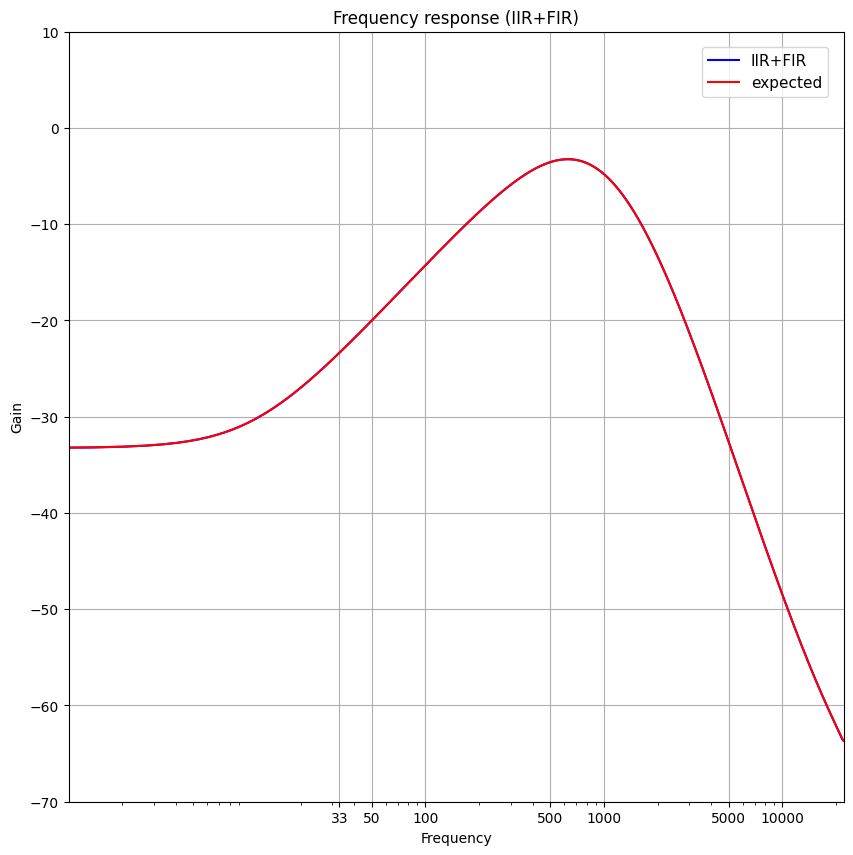

In [42]:
w, h = signal.freqz(fir, worN=2**15)

x = w * sr * 1.0 / (2 * np.pi)
plt.figure(figsize=(10,10))
plt.title("Frequency response (IIR+FIR)")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
plt.xlim((1, sr/2))
plt.ylim((-70, 10))
plt.xticks(xticks, xticks)

h =  np.multiply.reduce([ np.abs(f["hz"]) for f in filters]) * np.abs(h)

freqz_dB = 20 * np.log10(h)
expected_dB = -20 * np.log10(loss_m)
plt.plot(x, freqz_dB, 'b', label="IIR+FIR")
plt.plot(f_m, expected_dB, 'r', label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

h_actual = np.abs(h)           # 実装フィルタの振幅応答
h_expected = 1 / loss_m        # 理論フィルタの振幅応答

# 相対誤差RMSE（推奨）
relative_error = np.abs((h_actual - h_expected) / h_expected)
rmse_relative = np.sqrt(np.mean(relative_error**2))

# dB RMSE（補助的）
error_dB = np.abs(freqz_dB - expected_dB)
rmse_dB = np.sqrt(np.mean(error_dB**2))

# 最大誤差
max_relative_error = np.max(relative_error)
max_error_freq = wz[np.argmax(relative_error)] * sr / (2*np.pi)

print(f'相対誤差RMSE: {rmse_relative:.6f} = {rmse_relative*100:.3f}%')
print(f'dB RMSE: {rmse_dB:.6f} dB')
print(f'最大相対誤差: {max_relative_error:.6f} = {max_relative_error*100:.3f}% @ {max_error_freq:.1f} Hz')


In [43]:
# 係数を出力

data = [
  {
       "num": list(f["filter"].num),
       "den":  list(f["filter"].den),
   }
    for f in filters
]
data.append(list(fir))

print(json.dumps(data, indent=2))

[
  {
    "num": [
      0.0027293620390779223,
      0.0002239451280681405,
      -0.002162405616471103,
      -0.0007195307151076326,
      -6.105389511747936e-05
    ],
    "den": [
      1.0,
      -3.3926835929532446,
      4.312959033230201,
      -2.4347384558596867,
      0.5149375948434236
    ]
  },
  [
    -1.455162895940079e-06,
    2.7022775134117787e-06,
    -4.439928099957794e-06,
    6.820514684510746e-06,
    -9.955473357029213e-06,
    1.4091804906479038e-05,
    -1.9333482335757007e-05,
    2.608981712200495e-05,
    -3.440249047318325e-05,
    4.496227231741112e-05,
    -5.763722085289735e-05,
    7.360519637167829e-05,
    -9.235170462105547e-05,
    0.00011588867496242391,
    -0.00014294671416925997,
    0.00017694363068985612,
    -0.00021521532335404343,
    0.00026350552372891227,
    -0.00031668449031091954,
    0.00038426673565752635,
    -0.0004568962670841735,
    0.0005500705768456986,
    -0.0006473426243376244,
    0.0007734859644461501,
    -0.00090031